# Notes:
This notebook is used to predict demand of Victoria state (without using any future dataset)

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tsa_utils import *
from statsmodels.tsa.stattools import pacf
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# show float in two decimal form
plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 1) Load dataset

In [63]:
df = pd.read_csv("../../data/all.csv").reset_index(drop=True)
df.head(3)

,time,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period
0,2018-01-01 00:00:00,88.00,103.11,90.55,90.43,0.18,60.53,121.68,146.87,7100,1398,1091,4599,1
1,2018-01-01 00:30:00,91.86,107.17,92.28,92.46,0.15,43.07,118.73,131.68,6974,1359,1082,4398,2
2,2018-01-01 01:00:00,88.83,103.31,87.53,87.62,0.13,41.67,110.48,119.98,6790,1316,1071,4238,3


In [64]:
df = df[df.time <= '2021-08-11 23:30:00']
df.head(3)

,time,spot_price_nsw,spot_price_sa,spot_price_tas,spot_price_vic,inter_gen_nsw,inter_gen_sa,inter_gen_tas,inter_gen_vic,demand_nsw,demand_sa,demand_tas,demand_vic,period
0,2018-01-01 00:00:00,88.00,103.11,90.55,90.43,0.18,60.53,121.68,146.87,7100,1398,1091,4599,1
1,2018-01-01 00:30:00,91.86,107.17,92.28,92.46,0.15,43.07,118.73,131.68,6974,1359,1082,4398,2
2,2018-01-01 01:00:00,88.83,103.31,87.53,87.62,0.13,41.67,110.48,119.98,6790,1316,1071,4238,3


## 3) Feature Engineering

In [65]:
drop_columns = ['demand_nsw',
                'demand_sa',
                'demand_tas',
                'spot_price_nsw',
                'spot_price_sa',
                'spot_price_tas',
                'spot_price_vic', 
                'inter_gen_nsw', 'inter_gen_sa', 'inter_gen_tas', 'inter_gen_vic',]
vic = df.drop(columns=drop_columns)
vic.columns = ['time', 'demand_vic', 'period']
vic.head(3)

,time,demand_vic,period
0,2018-01-01 00:00:00,4599,1
1,2018-01-01 00:30:00,4398,2
2,2018-01-01 01:00:00,4238,3


In [67]:
# Feature engineering on datetime
vic['time'] = vic.time.astype('datetime64[ns]')
vic['month'] = vic.time.dt.month
vic['day'] = vic.time.dt.day
vic['day_of_year'] = vic.time.dt.dayofyear
vic['year'] = vic.time.dt.year
vic['weekday'] = vic['time'].apply(lambda x: x.weekday())
vic['week'] = vic.time.dt.week
vic['hour'] = vic.time.dt.hour

vic.loc[vic['month'].isin([12,1,2]), 'season'] = 1
vic.loc[vic['month'].isin([3,4,5]), 'season'] = 2
vic.loc[vic['month'].isin([6,7,8]), 'season'] = 3
vic.loc[vic['month'].isin([9, 10, 11]), 'season'] = 4
vic.tail(3)

,time,demand_vic,period,month,day,day_of_year,year,weekday,week,hour,season
63309,2021-08-11 22:30:00,5450,46,8,11,223,2021,2,32,22,3.00
63310,2021-08-11 23:00:00,5269,47,8,11,223,2021,2,32,23,3.00
63311,2021-08-11 23:30:00,5332,48,8,11,223,2021,2,32,23,3.00


In [68]:
# Add fourier terms
fourier_terms = add_fourier_terms(vic.time, year_k=3, week_k=3, day_k=3)
vic = pd.concat([vic, fourier_terms], 1).drop(columns=['datetime'])
vic.head(3)

,time,demand_vic,period,month,day,day_of_year,year,weekday,week,hour,...,week_sin2,week_cos2,week_sin3,week_cos3,hour_sin1,hour_cos1,hour_sin2,hour_cos2,hour_sin3,hour_cos3
0,2018-01-01 00:00:00,4599,1,1,1,1,2018,0,1,0,...,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
1,2018-01-01 00:30:00,4398,2,1,1,1,2018,0,1,0,...,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
2,2018-01-01 01:00:00,4238,3,1,1,1,2018,0,1,1,...,0.00,1.00,0.00,1.00,0.26,0.97,0.50,0.87,0.71,0.71


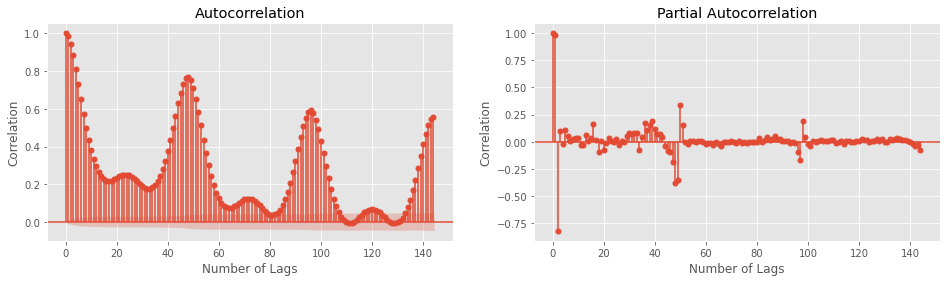

In [69]:
# Plot autocorrelation
nlags=144
plot_tsc(vic.demand_vic, lags=nlags)

In [70]:
# Add nlag features (choosing the first 10 highest autocorrelation nlag)
dict_pacf = dict()
list_pacf = pacf(df['demand_vic'], nlags=nlags)
for nlag in range(nlags):
    if nlag >= 48:
        dict_pacf[nlag] = list_pacf[nlag]
dict_pacf = {k: v for k, v in sorted(dict_pacf.items(), key=lambda item: abs(item[1]), reverse=True)}

# 10 highest pacf nlag
max_pacf_nlags = list(dict_pacf.keys())[:5]
for nlag in max_pacf_nlags:
    vic['n_lag'+str(nlag)] = df.reset_index()['demand_vic'].shift(nlag)

In [71]:
vic_train = vic[vic["time"] <= "2020-12-31 23:30:00"]
vic_cv = vic[(vic['time'] >= "2021-01-01 00:00:00") & (vic['time'] <= "2021-06-30 23:30:00")].reset_index(drop=True)
vic_test = vic[(vic['time'] >= "2021-07-01 00:00:00") & (vic['time'] <= "2021-08-11 23:30:00")].reset_index(drop=True)

In [72]:
X_train = vic_train.drop(columns=['demand_vic', 'time'])[nlags:]
y_train = vic_train.demand_vic[nlags:]
X_cv = vic_cv.drop(columns=['demand_vic', 'time'])
y_cv = vic_cv.demand_vic
X_test = vic_test.drop(columns=['demand_vic', 'time'])
y_test = vic_test.demand_vic
X_train.head(3)

,period,month,day,day_of_year,year,weekday,week,hour,season,year_sin1,...,hour_cos1,hour_sin2,hour_cos2,hour_sin3,hour_cos3,n_lag48,n_lag49,n_lag50,n_lag98,n_lag97
144,1,1,4,4,2018,3,1,0,1.00,0.07,...,1.00,0.00,1.00,0.00,1.00,4624.00,4616.00,4379.00,4228.00,4429.00
145,2,1,4,4,2018,3,1,0,1.00,0.07,...,1.00,0.00,1.00,0.00,1.00,4444.00,4624.00,4616.00,4429.00,4436.00
146,3,1,4,4,2018,3,1,1,1.00,0.07,...,0.97,0.50,0.87,0.71,0.71,4296.00,4444.00,4624.00,4436.00,4259.00


In [73]:
X_train.columns


Index(['period', 'month', 'day', 'day_of_year', 'year', 'weekday', 'week',
       'hour', 'season', 'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2',
       'year_sin3', 'year_cos3', 'week_sin1', 'week_cos1', 'week_sin2',
       'week_cos2', 'week_sin3', 'week_cos3', 'hour_sin1', 'hour_cos1',
       'hour_sin2', 'hour_cos2', 'hour_sin3', 'hour_cos3', 'n_lag48',
       'n_lag49', 'n_lag50', 'n_lag98', 'n_lag97'],
      dtype='object')

## 4) First look at Random Forest Regressor

In [74]:
rfr_clf = RandomForestRegressor(n_estimators=100)
rfr_clf = rfr_clf.fit(X_train, y_train)

Random Forest Regressor accuracy: 
Mean Absolute Percent Error: 0.0434
Root Mean Squared Error: 347.7397461845399


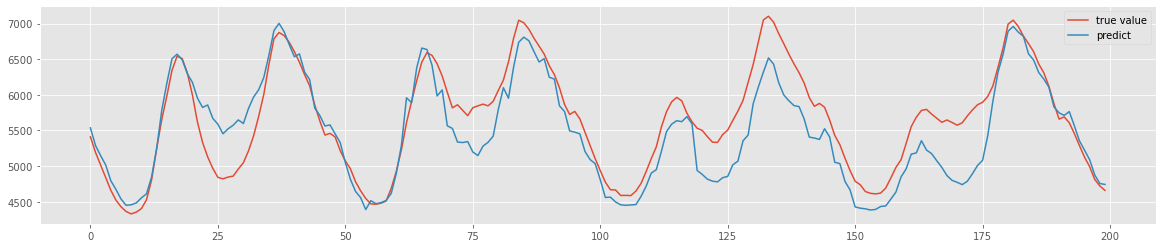

In [75]:
print("Random Forest Regressor accuracy: ")
rfr_result = rfr_clf.predict(X_test)
rfr_residuals = y_test - rfr_result
print('Mean Absolute Percent Error:', round(np.mean(abs(rfr_residuals/y_test)), 4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rfr_residuals**2)))

plt.figure(figsize=(20, 4))
plt.plot(y_test[:200], label='true value')
plt.plot(rfr_result[:200], label='predict')
plt.legend()
plt.show()

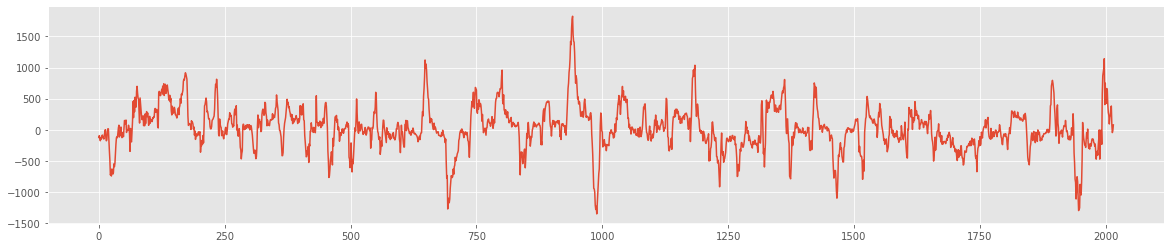

In [76]:
plt.figure(figsize=(20, 4))
plt.plot(rfr_residuals)
plt.show()

In [77]:
# Get numerical feature importances
importances = list(rfr_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: n_lag48              Importance: 0.62
Variable: week_sin1            Importance: 0.04
Variable: period               Importance: 0.03
Variable: weekday              Importance: 0.03
Variable: year_cos1            Importance: 0.03
Variable: day_of_year          Importance: 0.02
Variable: n_lag97              Importance: 0.02
Variable: day                  Importance: 0.01
Variable: year                 Importance: 0.01
Variable: week                 Importance: 0.01
Variable: hour                 Importance: 0.01
Variable: year_sin1            Importance: 0.01
Variable: year_sin2            Importance: 0.01
Variable: year_cos2            Importance: 0.01
Variable: year_sin3            Importance: 0.01
Variable: year_cos3            Importance: 0.01
Variable: week_cos1            Importance: 0.01
Variable: week_cos2            Importance: 0.01
Variable: week_cos3            Importance: 0.01
Variable: hour_sin1            Importance: 0.01
Variable: hour_cos1            Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## 6) Predict CV and Test period demand

### 6.1) Predict CV period demand

In [78]:
X_train = vic_train.drop(columns=['demand_vic', 'time'])[nlags:]
y_train = vic_train.demand_vic[nlags:]
X_cv = vic_cv.drop(columns=['demand_vic', 'time'])
y_cv = vic_cv.demand_vic

rfr_clf = RandomForestRegressor(n_estimators=100)
rfr_clf = rfr_clf.fit(X_train, y_train)

Random Forest Regressor accuracy: 
Mean Absolute Percent Error: 0.0796
Root Mean Squared Error: 447.26252159890885


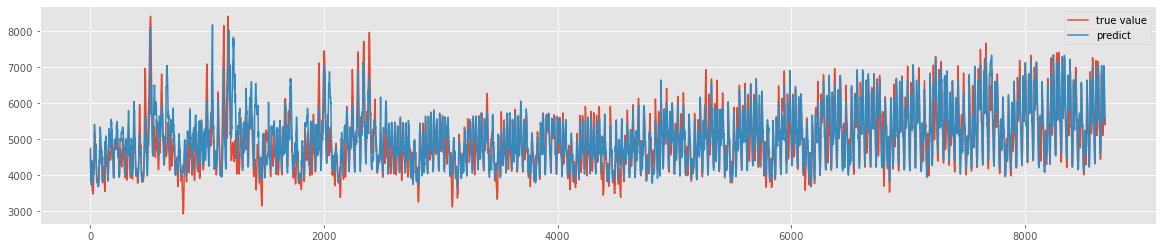

In [79]:
print("Random Forest Regressor accuracy: ")
rfr_result = rfr_clf.predict(X_cv)
rfr_residuals = y_cv - rfr_result
print('Mean Absolute Percent Error:', round(np.mean(abs(rfr_residuals/y_test)), 4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rfr_residuals**2)))

plt.figure(figsize=(20, 4))
plt.plot(y_cv, label='true value')
plt.plot(rfr_result, label='predict')
plt.legend()
plt.show()

In [80]:
vic_demand_cv_rfr = pd.DataFrame({'time': vic_cv.time, 'demand_vic': vic_cv.demand_vic})
vic_demand_cv_rfr['predicted_demand_vic'] = rfr_result
vic_demand_cv_rfr.tail(3)

,time,demand_vic,predicted_demand_vic
8685,2021-06-30 22:30:00,5653,5652.75
8686,2021-06-30 23:00:00,5397,5502.08
8687,2021-06-30 23:30:00,5487,5555.36


In [81]:
vic_demand_cv_rfr.to_csv('predictions/vic_demand_unknow_cv_rfr.csv', index=False, header=True)

### 6.2) Predict Test period demand

In [82]:
idx_test_start = 61296 # index of df(full) where test start
X_train = vic.drop(columns=['demand_vic', 'time'])[nlags:idx_test_start]
y_train = vic.demand_vic[nlags:idx_test_start]
X_test = vic_test.drop(columns=['demand_vic', 'time'])
y_test = vic_test.demand_vic

rfr_clf = RandomForestRegressor(n_estimators=100, random_state=1)
rfr_clf = rfr_clf.fit(X_train, y_train)

Random Forest Regressor accuracy: 
Mean Absolute Percent Error: 0.0426
Root Mean Squared Error: 337.34638457101516


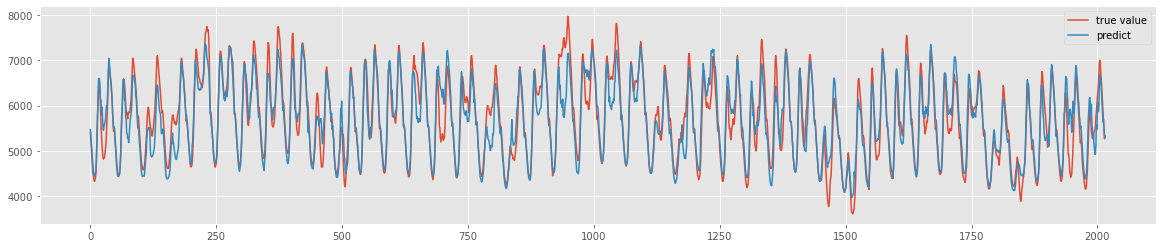

In [83]:
print("Random Forest Regressor accuracy: ")
rfr_result = rfr_clf.predict(X_test)
rfr_residuals = y_test - rfr_result
print('Mean Absolute Percent Error:', round(np.mean(abs(rfr_residuals/y_test)), 4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rfr_residuals**2)))

plt.figure(figsize=(20, 4))
plt.plot(y_test, label='true value')
plt.plot(rfr_result, label='predict')
plt.legend()
plt.show()

In [84]:
vic_demand_test_rfr = pd.DataFrame({'time': vic_test.time, 'demand_vic': vic_test.demand_vic})
vic_demand_test_rfr['predicted_demand_vic'] = rfr_result
vic_demand_test_rfr.tail(3)

,time,demand_vic,predicted_demand_vic
2013,2021-08-11 22:30:00,5450,5535.43
2014,2021-08-11 23:00:00,5269,5346.05
2015,2021-08-11 23:30:00,5332,5297.75


In [85]:
vic_demand_test_rfr.to_csv('predictions/vic_demand_unknow_test_rfr.csv', index=False, header=True)